In [1]:
import pickle
import numpy as np

import sys
sys.path.append('../../../')
import ndrought.drought_network as dnet
import ndrought.wrangle_v11 as dnw

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr

import os

/pool0/data/steinjao/drought/drought_impact/notebooks/analysis/drought_tracks/../../../ndrought/wrangle.py:17: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
cwd = '/pool0/home/steinadi/data/drought/drought_impact/data/thresh_experiments'

First let's check that the new method matches the old method

In [3]:
test_dtd_old = dnw.convert_pickle_to_dtd(f'{cwd}/spi180d/track/track_2800a_09r_1m.pickle')

In [4]:
#test_dtd_new = dnw.convert_pickle_to_dtd(f'{cwd}/spi180d/track/storage/track_2800a_09r_1m.pickle')

In [5]:
#test_summ, test_summ_grp = dnw.compute_track_summary_characterization(test_dtd_old, 5)
# ValueError: zero-size array to reduction operation maximum which has no identity

In [6]:
#test_dtd_old['t']

In [7]:
#test_dtd_new['t']

the new method jumps time on occasion .... don't like that. We'll stick with the old method.

Old method still has some empty paths ... we need to remove those.

In [8]:
test_dtd = test_dtd_old

In [9]:
new_x = []
for track in test_dtd['x']:
    if len(track) > 0:
        new_x.append(track)

In [10]:
for key in test_dtd.keys():
    var_tracks = test_dtd[key]
    trimmed_tracks = []
    for track in var_tracks:
        if len(track) > 0:
            trimmed_tracks.append(track)
    test_dtd[key] = trimmed_tracks

Now I want to get things down to a singular data value

In [11]:
test_summ, test_summ_grp = dnw.compute_track_summary_characterization(test_dtd, 5)

In [12]:
test_summ

,lifetime,distance,displacement,average velocity,similarity,xy_size,uv_size
0,50,5.773833e+05,4.428262e+05,1.154767e+04,0.911922,"[20249, 27852, 25621, 30914, 28851, 29592, 292...","[27852, 25621, 30914, 28851, 29592, 29227, 359..."
1,35,1.108997e+06,7.936584e+05,3.168564e+04,0.833403,"[3264, 61640, 66991, 65613, 66198, 66518, 6439...","[61640, 66991, 65613, 66198, 66518, 64396, 767..."
2,15,1.019046e+06,1.012487e+06,6.793637e+04,0.728535,"[3413, 3310, 3248, 76702]","[3310, 3248, 76702, 83308]"
3,5,1.629329e+05,1.627052e+05,3.258658e+04,0.625033,"[4127, 6933]","[6933, 10588]"
4,0,3.382374e+04,3.382374e+04,inf,0.804675,[6093],[7572]
...,...,...,...,...,...,...,...
247,15,1.276537e+04,8.781319e+03,8.510249e+02,0.962267,"[3191, 3110, 3059, 3399]","[3110, 3059, 3399, 3368]"
248,15,8.872528e+04,7.828593e+04,5.915019e+03,0.911097,"[8425, 9061, 10867, 11415]","[9061, 10867, 11415, 10602]"
249,0,2.933334e+04,2.933334e+04,inf,0.765566,[3455],[4513]
250,0,7.750770e+04,7.750770e+04,inf,0.614339,[8809],[14339]


In [13]:
bins=[0, 30, 60, 90, 180, 365, 730, 1825, 7*1163]

In [14]:
test_grp_obj = test_summ.groupby(pd.cut(test_summ.lifetime, bins=bins))

In [15]:
group_keys = [key for key in test_grp_obj.groups.keys()]

In [16]:
test_grp_obj.get_group(group_keys[0])['lifetime'].mean()

12.030075187969924

Success!

In [17]:
def groupby_intervals(data:pd.DataFrame, bins=[0, 30, 60, 90, 180, 365, 730, 1825, 7*1163]):
    grp_obj = data.groupby(pd.cut(data.lifetime, bins=bins))
    keys = [key for key in grp_obj.groups.keys()]
    return grp_obj, keys

In [18]:
groupby_intervals(test_summ)

(<pandas.core.groupby.generic.DataFrameGroupBy object at 0x7f9ba1b2d810>,
 [Interval(0, 30, closed='right'),
  Interval(30, 60, closed='right'),
  Interval(60, 90, closed='right'),
  Interval(90, 180, closed='right'),
  Interval(180, 365, closed='right'),
  Interval(365, 730, closed='right'),
  Interval(730, 1825, closed='right'),
  Interval(1825, 8141, closed='right')])

Nifty

In [19]:
track_dir = f'{cwd}/spi180d/track'

In [20]:
files = os.listdir('/pool0/home/steinadi/data/drought/drought_impact/data/thresh_experiments/spi180d/track')

In [21]:
all_dtd = {}
all_summ = {}
all_summ_grp = {}
all_grp_obj = {}

for file in files:
    dtd = dnw.convert_pickle_to_dtd(f'{track_dir}/{file}')
    for key in dtd.keys():
        var_tracks = dtd[key]
        trimmed_tracks = []
        for track in var_tracks:
            if len(track) > 0:
                trimmed_tracks.append(track)
        dtd[key] = trimmed_tracks
    dtd = dnw.prune_tracks(dtd)

    summ, summ_grp = dnw.compute_track_summary_characterization(dtd, 5)
    grp_obj, __ = groupby_intervals(summ)

    all_dtd[file] = dtd
    all_summ[file] = summ
    all_summ_grp[file] = summ_grp
    all_grp_obj[file] = grp_obj

I want to make a matrix of values and plot them as either a heatmap or 3d map

first I need to get the parameters out of the file names

In [22]:
# get area threshold
np.float64(files[0].split("_")[1][:-1])

1600.0

In [23]:
# get continuation threshold
np.float64(files[0].split("_")[2][:-1])/10

0.0

In [24]:
def get_thresh_from_file(file:str):
    arguments = file.split("_")
    a_thresh = np.float64(arguments[1][:-1])
    r_thresh = np.float64(arguments[2][:-1])/10
    return a_thresh, r_thresh

In [25]:
all_a_thresh = []
all_r_thresh = []

for file in files:
    a_thresh, r_thresh = get_thresh_from_file(file)
    all_a_thresh.append(a_thresh)
    all_r_thresh.append(r_thresh)

In [26]:
a_thresh_set = list(set(all_a_thresh))
a_thresh_set.sort()
r_thresh_set = list(set(all_r_thresh))
r_thresh_set.sort()

In [27]:
a_thresh_map = {a_thresh:i for i, a_thresh in enumerate(a_thresh_set)}
a_thresh_map

{400.0: 0,
 600.0: 1,
 800.0: 2,
 1000.0: 3,
 1200.0: 4,
 1400.0: 5,
 1600.0: 6,
 1800.0: 7,
 2000.0: 8,
 2200.0: 9,
 2400.0: 10,
 2600.0: 11,
 2800.0: 12,
 3000.0: 13}

In [28]:
r_thresh_map = {r_thresh:i for i, r_thresh in enumerate(r_thresh_set)}
r_thresh_map

{0.0: 0,
 0.1: 1,
 0.2: 2,
 0.3: 3,
 0.4: 4,
 0.5: 5,
 0.6: 6,
 0.7: 7,
 0.8: 8,
 0.9: 9,
 1.0: 10}

In [29]:
empty_mat = np.nan * np.zeros((len(set(all_a_thresh)), len(set(all_r_thresh))))
empty_mat

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [30]:
all_summ[file]['lifetime'].mean()

11.0

In [31]:
lifetime_mat = empty_mat.copy()

for file in files:
    lifetime_mean = all_summ[file]['lifetime'].mean()
    a_thresh, r_thresh = get_thresh_from_file(file)
    i = a_thresh_map[a_thresh]
    j = r_thresh_map[r_thresh]

    lifetime_mat[i, j] = lifetime_mean

lifetime_mat

array([[43.36380256, 42.9379562 , 41.12612613, 38.28178694, 34.71728595,
        30.02262443, 26.15328467, 19.75694444, 13.49869452,  8.55656697,
         5.10884354],
       [46.13436123, 45.85903084, 44.38864629, 41.86046512, 37.26190476,
        31.70708955, 28.00182482, 21.56574394, 14.60898502,  9.14089347,
         5.42213884],
       [48.92207792, 48.79220779, 48.14285714, 45.37783375, 40.30805687,
        34.43080357, 30.05387931, 22.68442623, 15.1497006 ,  9.58163265,
         5.43333333],
       [51.89349112, 51.81952663, 51.20588235, 48.31908832, 42.86096257,
        36.84478372, 32.40694789, 24.68309859, 16.58198614, 10.12672811,
         5.78358209],
       [53.52564103, 53.52564103, 52.5399361 , 50.0931677 , 45.14749263,
        39.16666667, 34.50684932, 26.35064935, 17.37913486, 10.44191919,
         5.51075269],
       [56.87943262, 56.87943262, 55.9540636 , 53.27054795, 47.83870968,
        41.6       , 35.67567568, 27.05382436, 17.96143251, 10.98901099,
         5.414

/tmp/ipykernel_4078874/2561307839.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/2561307839.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


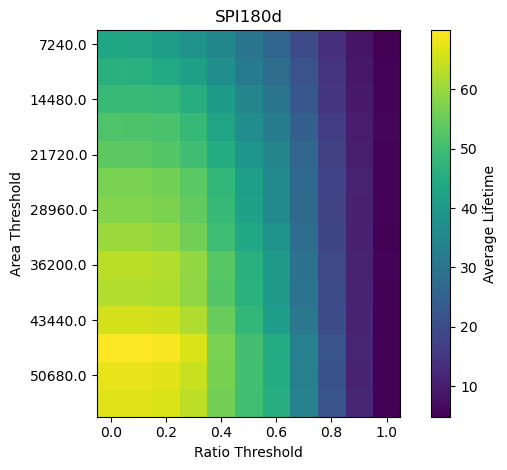

In [32]:
fig, ax = plt.subplots()

im = ax.imshow(lifetime_mat)#, vmin=0, vmax=30)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Average Lifetime')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

In [33]:
distance_mat = empty_mat.copy()

for file in files:
    distance_mean = all_summ[file]['distance'].mean()
    a_thresh, r_thresh = get_thresh_from_file(file)
    i = a_thresh_map[a_thresh]
    j = r_thresh_map[r_thresh]

    distance_mat[i, j] = distance_mean

/tmp/ipykernel_4078874/1028310451.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/1028310451.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


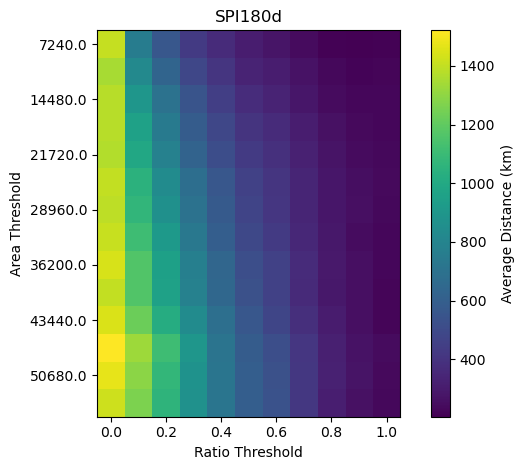

In [34]:
fig, ax = plt.subplots()

im = ax.imshow(distance_mat/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Average Distance (km)')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

In [35]:
def get_mean_array(summ, files, var):

    all_a_thresh = []
    all_r_thresh = []

    for file in files:
        a_thresh, r_thresh = get_thresh_from_file(file)
        all_a_thresh.append(a_thresh)
        all_r_thresh.append(r_thresh)

    a_thresh_set = list(set(all_a_thresh))
    a_thresh_set.sort()
    r_thresh_set = list(set(all_r_thresh))
    r_thresh_set.sort()
    a_thresh_map = {a_thresh:i for i, a_thresh in enumerate(a_thresh_set)}
    r_thresh_map = {r_thresh:i for i, r_thresh in enumerate(r_thresh_set)}

    mean_mat = np.nan * np.zeros((len(set(all_a_thresh)), len(set(all_r_thresh))))

    for file in files:
        mean_val = summ[file][var].mean()
        a_thresh, r_thresh = get_thresh_from_file(file)
        i = a_thresh_map[a_thresh]
        j = r_thresh_map[r_thresh]

        mean_mat[i, j] = mean_val

    return mean_mat

Double check this works

/tmp/ipykernel_4078874/2356907691.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/2356907691.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


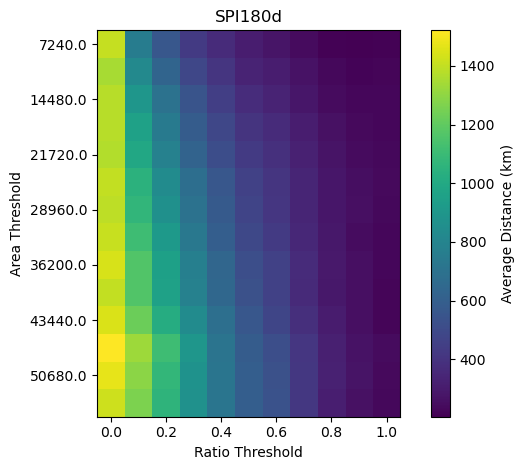

In [36]:
fig, ax = plt.subplots()

im = ax.imshow(get_mean_array(all_summ, files, 'distance')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Average Distance (km)')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

Yay

/tmp/ipykernel_4078874/2005592486.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/2005592486.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


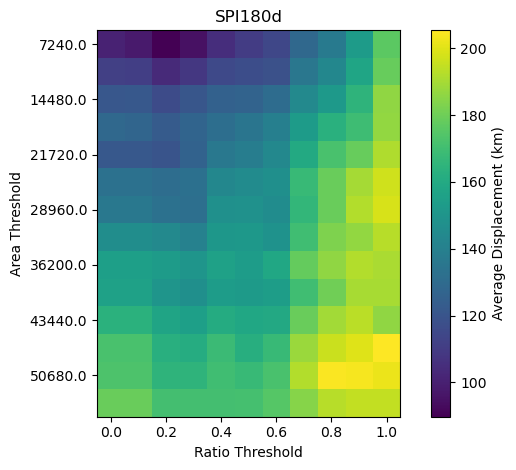

In [37]:
fig, ax = plt.subplots()

im = ax.imshow(get_mean_array(all_summ, files, 'displacement')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Average Displacement (km)')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_4078874/1341644255.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/1341644255.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


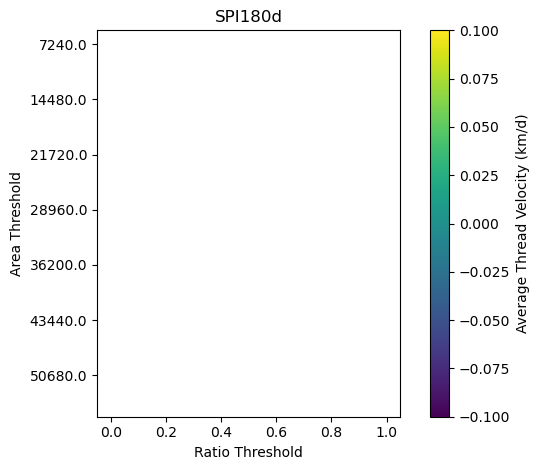

In [38]:
fig, ax = plt.subplots()

im = ax.imshow(get_mean_array(all_summ, files, 'average velocity')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Average Thread Velocity (km/d)')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

wtf

In [39]:
get_mean_array(all_summ, files, 'average velocity')/1e3

array([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]])

Hm ..

In [40]:
np.mean([0.4, np.inf])

inf

Ah, so the existence of some divide by zeros is resulting in the whole mean being inf

/tmp/ipykernel_4078874/2022844622.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/2022844622.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


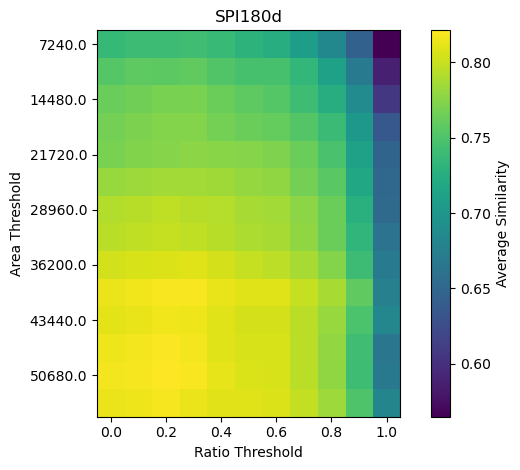

In [41]:
fig, ax = plt.subplots()

im = ax.imshow(get_mean_array(all_summ, files, 'similarity'))
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Average Similarity')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_4078874/1281827286.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/1281827286.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


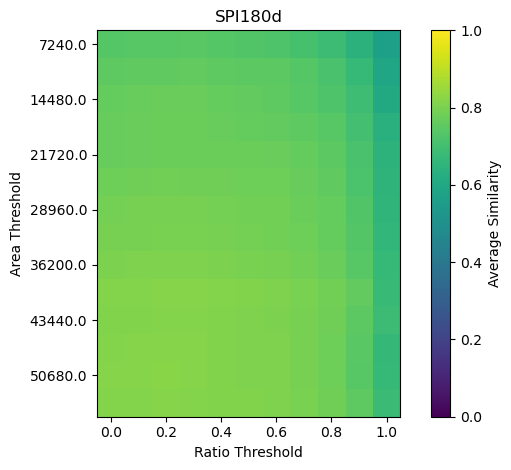

In [42]:
fig, ax = plt.subplots()

im = ax.imshow(get_mean_array(all_summ, files, 'similarity'), vmin=0, vmax=1)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Average Similarity')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

In [43]:
def get_max_array(summ, files, var):

    all_a_thresh = []
    all_r_thresh = []

    for file in files:
        a_thresh, r_thresh = get_thresh_from_file(file)
        all_a_thresh.append(a_thresh)
        all_r_thresh.append(r_thresh)

    a_thresh_set = list(set(all_a_thresh))
    a_thresh_set.sort()
    r_thresh_set = list(set(all_r_thresh))
    r_thresh_set.sort()
    a_thresh_map = {a_thresh:i for i, a_thresh in enumerate(a_thresh_set)}
    r_thresh_map = {r_thresh:i for i, r_thresh in enumerate(r_thresh_set)}

    max_mat = np.nan * np.zeros((len(set(all_a_thresh)), len(set(all_r_thresh))))

    for file in files:
        max_val = summ[file][var].max()
        a_thresh, r_thresh = get_thresh_from_file(file)
        i = a_thresh_map[a_thresh]
        j = r_thresh_map[r_thresh]

        max_mat[i, j] = max_val

    return max_mat

In [44]:
def get_min_array(summ, files, var):

    all_a_thresh = []
    all_r_thresh = []

    for file in files:
        a_thresh, r_thresh = get_thresh_from_file(file)
        all_a_thresh.append(a_thresh)
        all_r_thresh.append(r_thresh)

    a_thresh_set = list(set(all_a_thresh))
    a_thresh_set.sort()
    r_thresh_set = list(set(all_r_thresh))
    r_thresh_set.sort()
    a_thresh_map = {a_thresh:i for i, a_thresh in enumerate(a_thresh_set)}
    r_thresh_map = {r_thresh:i for i, r_thresh in enumerate(r_thresh_set)}

    min_mat = np.nan * np.zeros((len(set(all_a_thresh)), len(set(all_r_thresh))))

    for file in files:
        min_val = summ[file][var].min()
        a_thresh, r_thresh = get_thresh_from_file(file)
        i = a_thresh_map[a_thresh]
        j = r_thresh_map[r_thresh]

        min_mat[i, j] = min_val

    return min_mat

## Maximums

/tmp/ipykernel_4078874/313800898.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/313800898.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


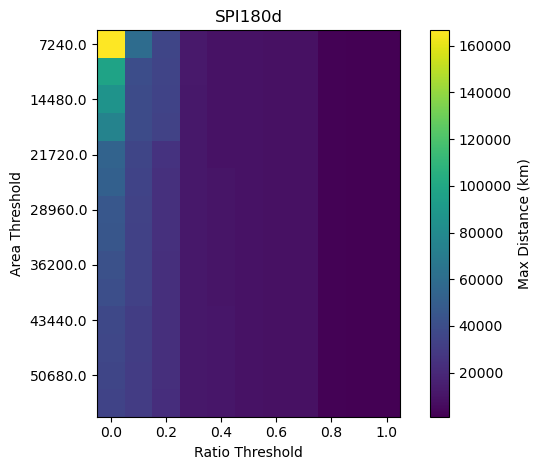

In [45]:
fig, ax = plt.subplots()

im = ax.imshow(get_max_array(all_summ, files, 'distance')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Max Distance (km)')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_4078874/254927776.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/254927776.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


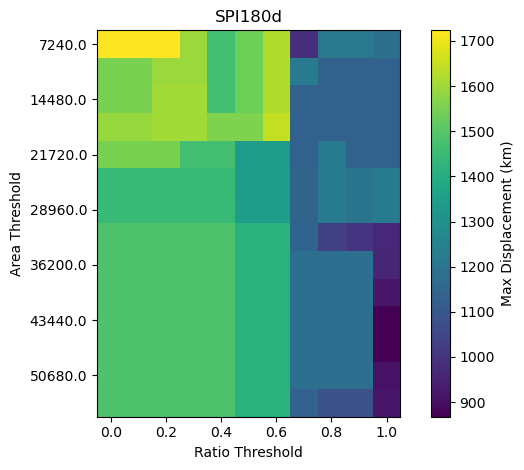

In [46]:
fig, ax = plt.subplots()

im = ax.imshow(get_max_array(all_summ, files, 'displacement')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Max Displacement (km)')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_4078874/3695484447.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/3695484447.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


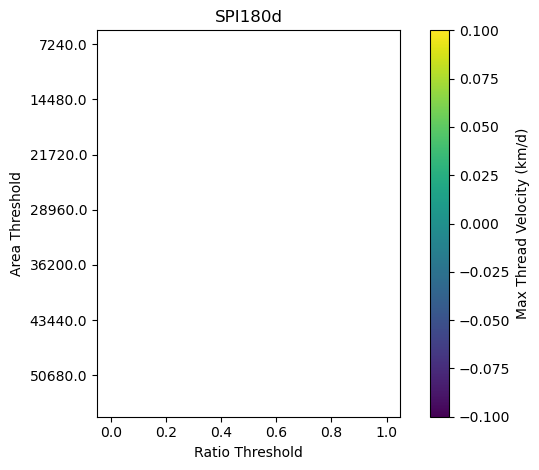

In [47]:
fig, ax = plt.subplots()

im = ax.imshow(get_max_array(all_summ, files, 'average velocity')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Max Thread Velocity (km/d)')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_4078874/2183082993.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/2183082993.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


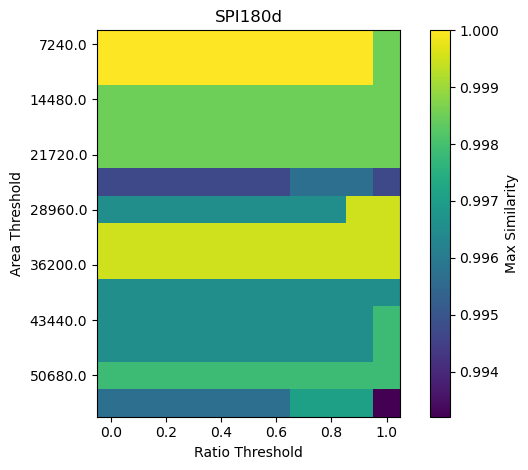

In [48]:
fig, ax = plt.subplots()

im = ax.imshow(get_max_array(all_summ, files, 'similarity'))
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Max Similarity')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_4078874/3056547791.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/3056547791.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


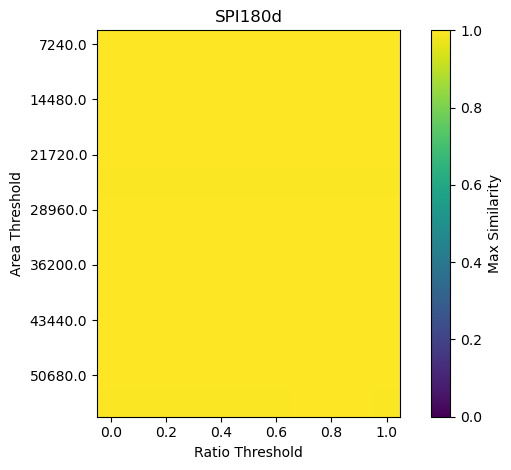

In [49]:
fig, ax = plt.subplots()

im = ax.imshow(get_max_array(all_summ, files, 'similarity'), vmin=0, vmax=1)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Max Similarity')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

## Minimums

/tmp/ipykernel_4078874/666053625.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/666053625.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


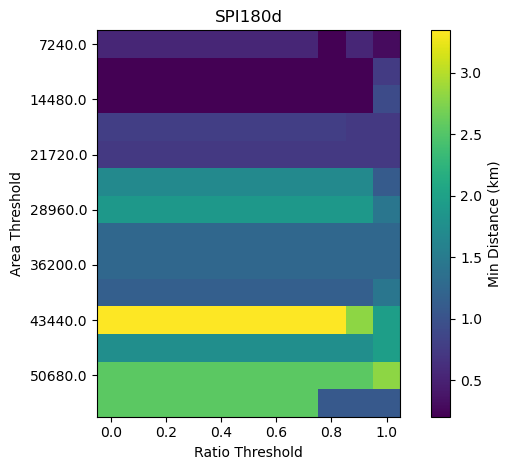

In [50]:
fig, ax = plt.subplots()

im = ax.imshow(get_min_array(all_summ, files, 'distance')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Min Distance (km)')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_4078874/1194118120.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/1194118120.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


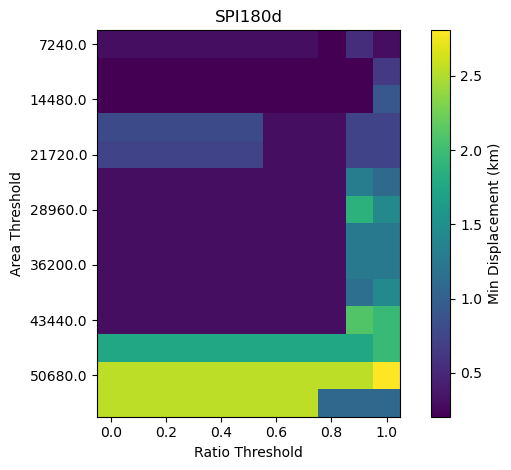

In [51]:
fig, ax = plt.subplots()

im = ax.imshow(get_min_array(all_summ, files, 'displacement')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Min Displacement (km)')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_4078874/2831659648.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/2831659648.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


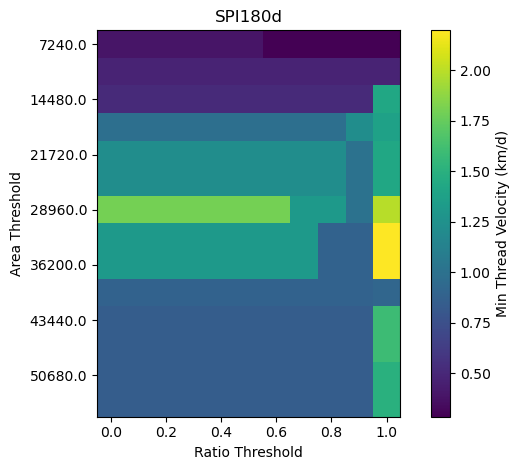

In [52]:
fig, ax = plt.subplots()

im = ax.imshow(get_min_array(all_summ, files, 'average velocity')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Min Thread Velocity (km/d)')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_4078874/129082240.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/129082240.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


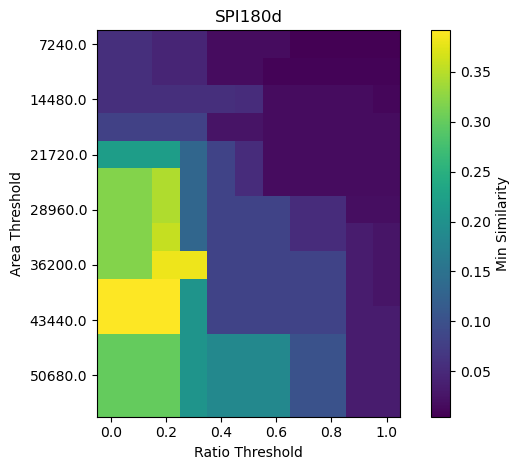

In [53]:
fig, ax = plt.subplots()

im = ax.imshow(get_min_array(all_summ, files, 'similarity'))
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Min Similarity')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_4078874/1066127430.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/1066127430.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


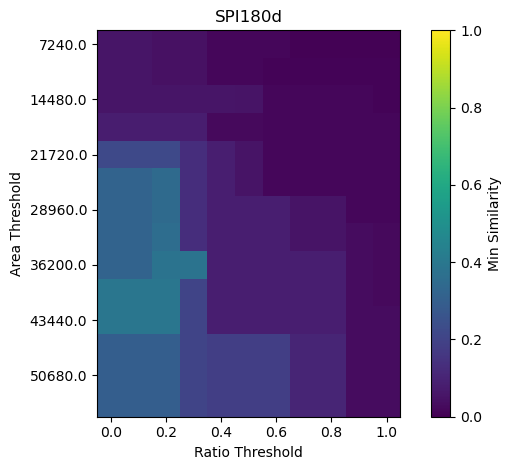

In [54]:
fig, ax = plt.subplots()

im = ax.imshow(get_min_array(all_summ, files, 'similarity'), vmin=0, vmax=1)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Min Similarity')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

## Standard Deviation

In [55]:
def get_std_array(summ, files, var):

    all_a_thresh = []
    all_r_thresh = []

    for file in files:
        a_thresh, r_thresh = get_thresh_from_file(file)
        all_a_thresh.append(a_thresh)
        all_r_thresh.append(r_thresh)

    a_thresh_set = list(set(all_a_thresh))
    a_thresh_set.sort()
    r_thresh_set = list(set(all_r_thresh))
    r_thresh_set.sort()
    a_thresh_map = {a_thresh:i for i, a_thresh in enumerate(a_thresh_set)}
    r_thresh_map = {r_thresh:i for i, r_thresh in enumerate(r_thresh_set)}

    std_mat = np.nan * np.zeros((len(set(all_a_thresh)), len(set(all_r_thresh))))

    for file in files:
        std_val = summ[file][var].std()
        a_thresh, r_thresh = get_thresh_from_file(file)
        i = a_thresh_map[a_thresh]
        j = r_thresh_map[r_thresh]

        std_mat[i, j] = std_val

    return std_mat

/tmp/ipykernel_4078874/2947343233.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/2947343233.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


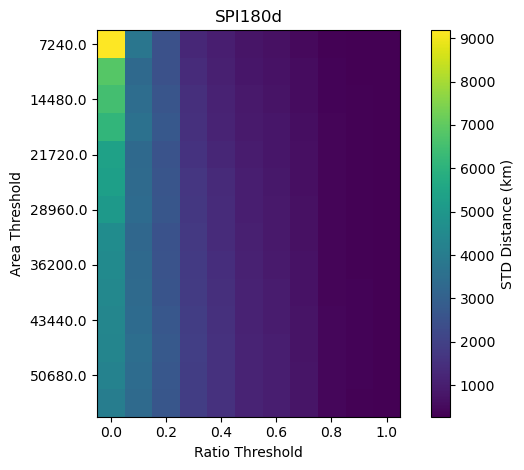

In [56]:
fig, ax = plt.subplots()

im = ax.imshow(get_std_array(all_summ, files, 'distance')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='STD Distance (km)')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_4078874/2553192060.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/2553192060.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


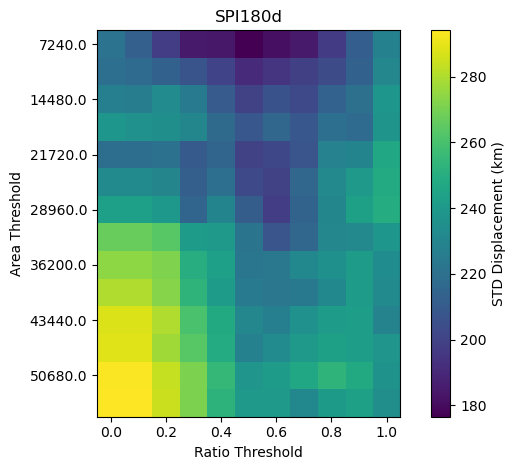

In [57]:
fig, ax = plt.subplots()

im = ax.imshow(get_std_array(all_summ, files, 'displacement')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='STD Displacement (km)')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_4078874/4036238081.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/4036238081.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


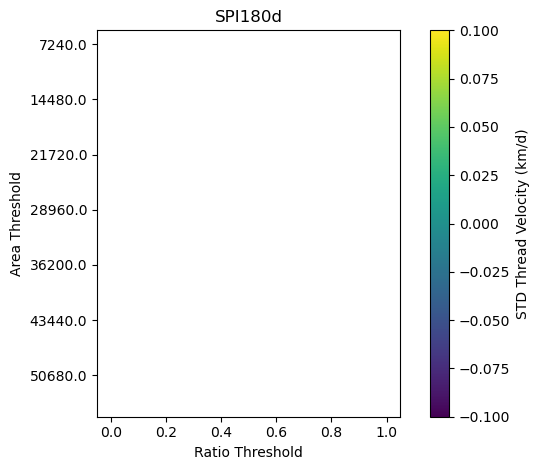

In [58]:
fig, ax = plt.subplots()

im = ax.imshow(get_std_array(all_summ, files, 'average velocity')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='STD Thread Velocity (km/d)')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_4078874/2494327682.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/2494327682.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


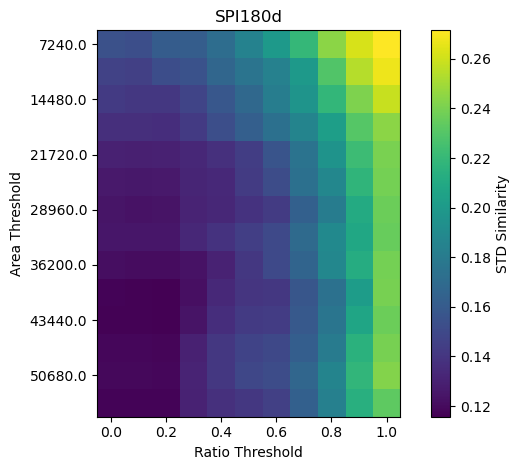

In [59]:
fig, ax = plt.subplots()

im = ax.imshow(get_std_array(all_summ, files, 'similarity'))
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='STD Similarity')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

## Count

In [60]:
def get_count_array(summ, files, var):

    all_a_thresh = []
    all_r_thresh = []

    for file in files:
        a_thresh, r_thresh = get_thresh_from_file(file)
        all_a_thresh.append(a_thresh)
        all_r_thresh.append(r_thresh)

    a_thresh_set = list(set(all_a_thresh))
    a_thresh_set.sort()
    r_thresh_set = list(set(all_r_thresh))
    r_thresh_set.sort()
    a_thresh_map = {a_thresh:i for i, a_thresh in enumerate(a_thresh_set)}
    r_thresh_map = {r_thresh:i for i, r_thresh in enumerate(r_thresh_set)}

    count_mat = np.nan * np.zeros((len(set(all_a_thresh)), len(set(all_r_thresh))))

    for file in files:
        count_val = summ[file][var].count()
        a_thresh, r_thresh = get_thresh_from_file(file)
        i = a_thresh_map[a_thresh]
        j = r_thresh_map[r_thresh]

        count_mat[i, j] = count_val

    return count_mat

/tmp/ipykernel_4078874/93604073.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/93604073.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])


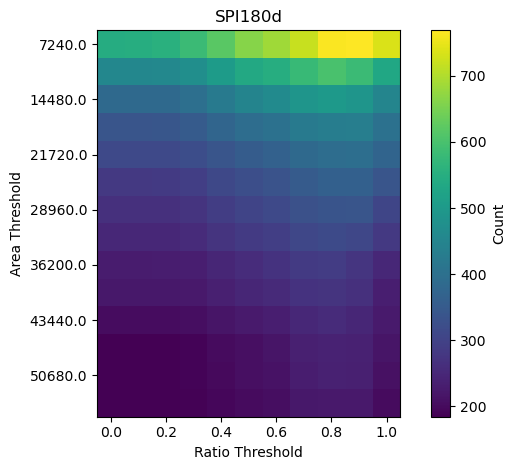

In [61]:
fig, ax = plt.subplots()

im = ax.imshow(get_count_array(all_summ, files, 'similarity'))
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Count')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

## Intersection w/ Count

/tmp/ipykernel_4078874/2114589.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/2114589.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
/tmp/ipykernel_4078874/2114589.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = axs[1].imshow(get_mean_array(all_summ, files, 'displacement')/1e3, cmap=plt.cm.get_cmap('viridis_r'))
/tmp/ipykernel_4078874/2114589.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/2114589.py:13: UserWarning: FixedForm

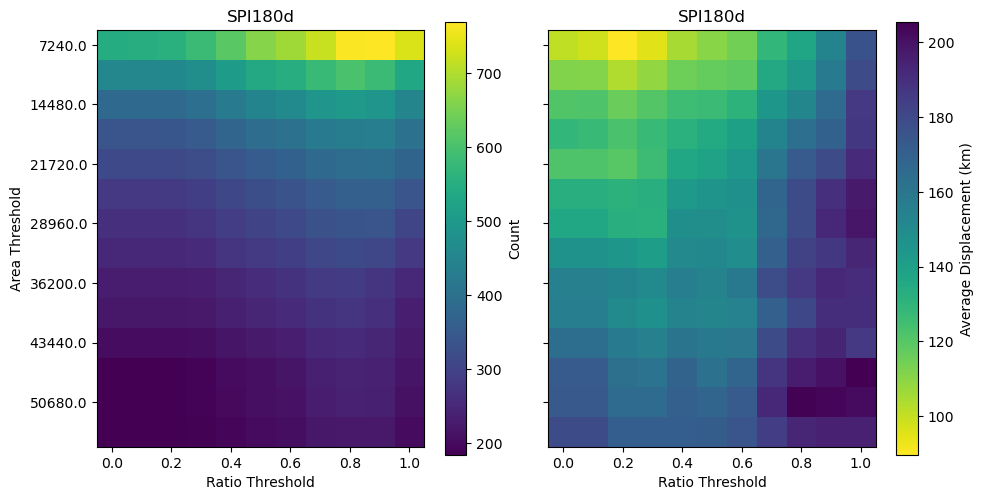

In [62]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))

im = axs[0].imshow(get_count_array(all_summ, files, 'similarity'))
axs[0].set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
axs[0].set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Count', ax=axs[0])
axs[0].set_title('SPI180d')
axs[0].set_ylabel('Area Threshold')
axs[0].set_xlabel("Ratio Threshold")

im = axs[1].imshow(get_mean_array(all_summ, files, 'displacement')/1e3, cmap=plt.cm.get_cmap('viridis_r'))
axs[1].set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
axs[1].set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Average Displacement (km)', ax=axs[1])
axs[1].set_title('SPI180d')
#axs[1].set_ylabel('Area Threshold')
axs[1].set_xlabel("Ratio Threshold")

plt.tight_layout()



/tmp/ipykernel_4078874/2856255328.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(get_count_array(all_summ, files, 'similarity'), cmap=plt.cm.get_cmap('Reds_r'), alpha=0.5)
/tmp/ipykernel_4078874/2856255328.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_4078874/2856255328.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
/tmp/ipykernel_4078874/2856255328.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` inst

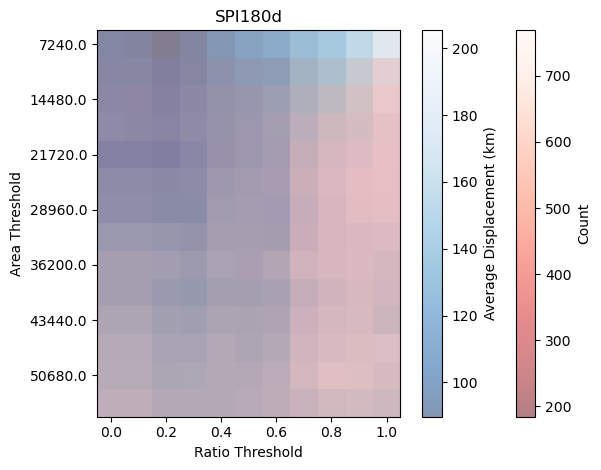

In [63]:
fig, ax = plt.subplots()

im = ax.imshow(get_count_array(all_summ, files, 'similarity'), cmap=plt.cm.get_cmap('Reds_r'), alpha=0.5)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Count')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")

im = ax.imshow(get_mean_array(all_summ, files, 'displacement')/1e3, cmap=plt.cm.get_cmap('Blues_r'), alpha=0.5)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(0, 3200, 400)])
fig.colorbar(im, label='Average Displacement (km)')
ax.set_title('SPI180d')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")

plt.tight_layout()

# Line Plots

In [64]:
mean_distance = get_mean_array(all_summ, files, 'distance')
std_distance = get_std_array(all_summ, files, 'distance')
max_distance = get_max_array(all_summ, files, 'distance')
min_distance = get_min_array(all_summ, files, 'distance')

/tmp/ipykernel_4078874/3035575683.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


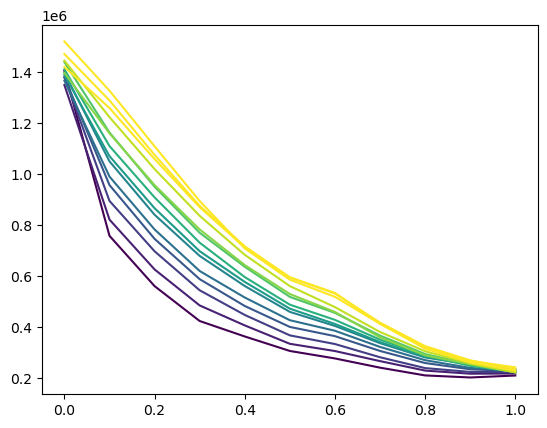

In [65]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('viridis')

for i in np.arange(mean_distance.shape[0]):
    #ax.fill_between(r_thresh_set, mean_distance[i,:]+std_distance[i,:], mean_distance[i,:]-std_distance[i,:], color=cmap(i/mean_distance.shape[1]), alpha=0.1)
    #ax.fill_between(r_thresh_set, max_distance[i,:], min_distance[i,:], color=cmap(i/mean_distance.shape[1]), alpha=0.1)
    ax.plot(r_thresh_set, mean_distance[i,:], color=cmap(i/mean_distance.shape[1]))

/tmp/ipykernel_4078874/992416708.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


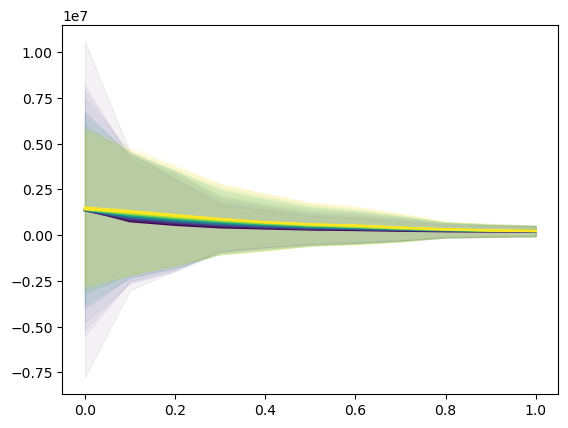

In [66]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('viridis')

for i in np.arange(mean_distance.shape[0]):
    ax.fill_between(r_thresh_set, mean_distance[i,:]+std_distance[i,:], mean_distance[i,:]-std_distance[i,:], color=cmap(i/mean_distance.shape[1]), alpha=0.05)
    ax.plot(r_thresh_set, mean_distance[i,:], color=cmap(i/mean_distance.shape[1]))

So adding in +/- 1 std is really wild it seems

/tmp/ipykernel_4078874/3952418607.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
/tmp/ipykernel_4078874/3952418607.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


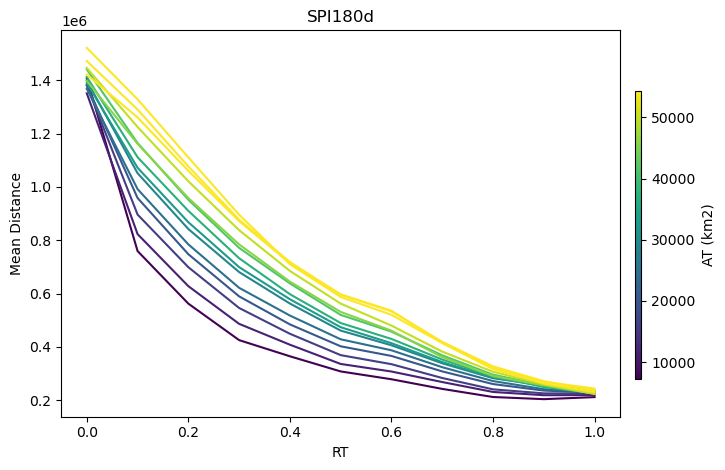

In [67]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('viridis')

mean_var = get_mean_array(all_summ, files, 'distance')

for i in np.arange(mean_var.shape[0]):
    ax.plot(r_thresh_set, mean_var[i,:], color=cmap(i/mean_var.shape[1]), label=f'{np.round(18.1*a_thresh_set[i])} AT')
    #ax.legend()
    ax.set_xlabel('RT')
    ax.set_ylabel('Mean Distance')
    ax.set_title('SPI180d')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.0, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()

/tmp/ipykernel_4078874/3329854863.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
/tmp/ipykernel_4078874/3329854863.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


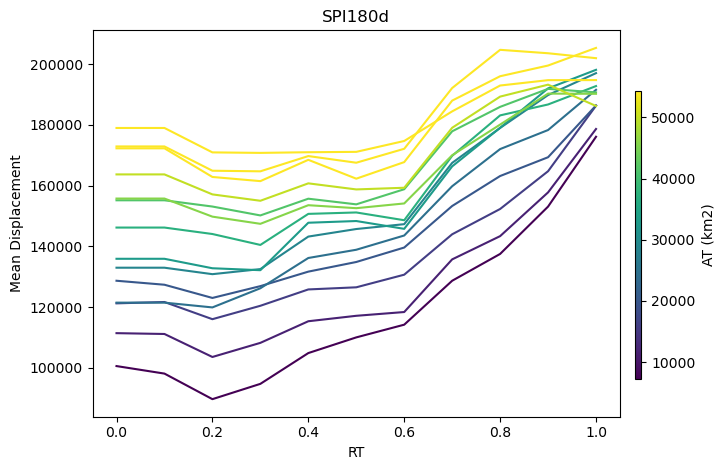

In [68]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('viridis')

mean_var = get_mean_array(all_summ, files, 'displacement')

for i in np.arange(mean_var.shape[0]):
    ax.plot(r_thresh_set, mean_var[i,:], color=cmap(i/mean_var.shape[1]), label=f'{np.round(18.1*a_thresh_set[i])} AT')
    #ax.legend()
    ax.set_xlabel('RT')
    ax.set_ylabel('Mean Displacement')
    ax.set_title('SPI180d')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.0, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()

/tmp/ipykernel_4078874/3425840945.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
/tmp/ipykernel_4078874/3425840945.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


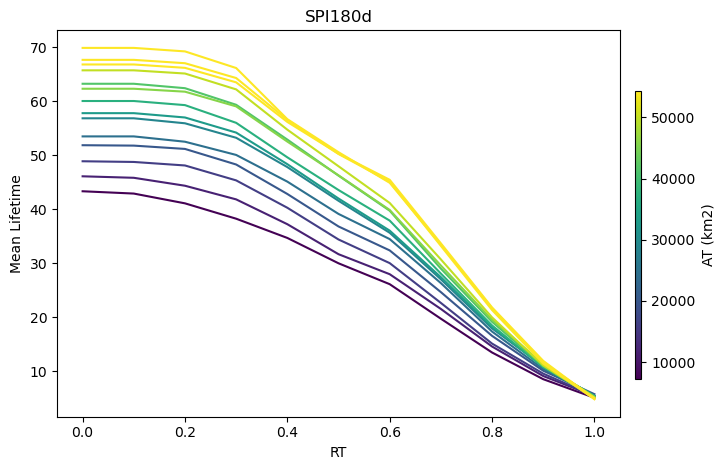

In [69]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('viridis')

mean_var = get_mean_array(all_summ, files, 'lifetime')

for i in np.arange(mean_var.shape[0]):
    ax.plot(r_thresh_set, mean_var[i,:], color=cmap(i/mean_var.shape[1]), label=f'{np.round(18.1*a_thresh_set[i])} AT')
    #ax.legend()
    ax.set_xlabel('RT')
    ax.set_ylabel('Mean Lifetime')
    ax.set_title('SPI180d')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.0, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()

/tmp/ipykernel_4078874/4157336507.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
/tmp/ipykernel_4078874/4157336507.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


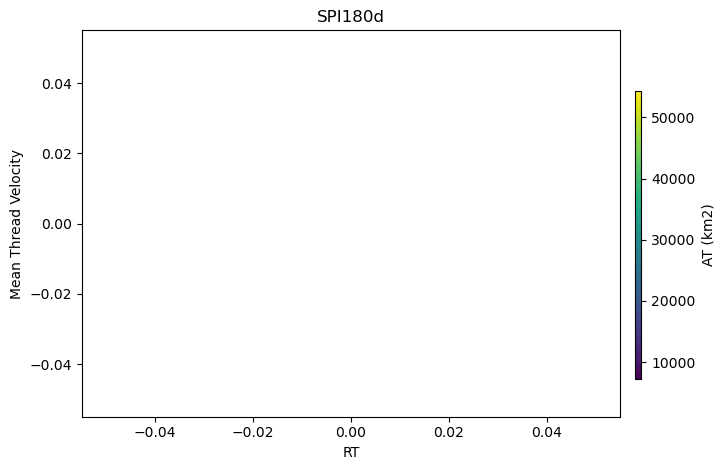

In [70]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('viridis')

mean_var = get_mean_array(all_summ, files, 'average velocity')

for i in np.arange(mean_var.shape[0]):
    ax.plot(r_thresh_set, mean_var[i,:], color=cmap(i/mean_var.shape[1]), label=f'{np.round(18.1*a_thresh_set[i])} AT')
    #ax.legend()
    ax.set_xlabel('RT')
    ax.set_ylabel('Mean Thread Velocity')
    ax.set_title('SPI180d')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.0, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()

/tmp/ipykernel_4078874/2547451726.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
/tmp/ipykernel_4078874/2547451726.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


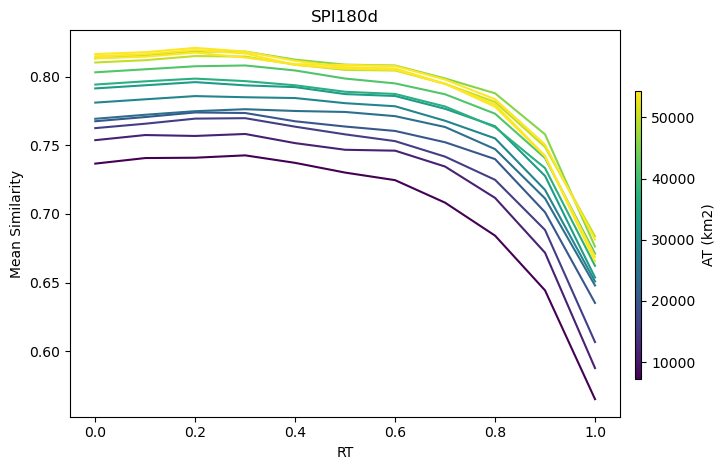

In [71]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('viridis')

mean_var = get_mean_array(all_summ, files, 'similarity')

for i in np.arange(mean_var.shape[0]):
    ax.plot(r_thresh_set, mean_var[i,:], color=cmap(i/mean_var.shape[1]), label=f'{np.round(18.1*a_thresh_set[i])} AT')
    #ax.legend()
    ax.set_xlabel('RT')
    ax.set_ylabel('Mean Similarity')
    ax.set_title('SPI180d')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.0, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()

/tmp/ipykernel_4078874/874381475.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
/tmp/ipykernel_4078874/874381475.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


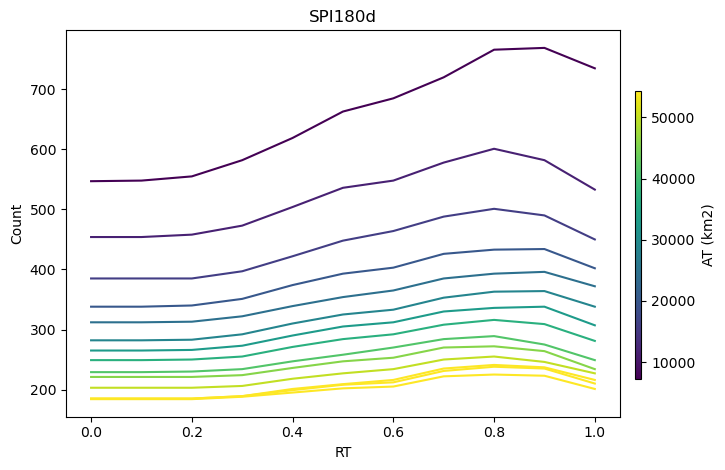

In [72]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('viridis')

count_var = get_count_array(all_summ, files, 'similarity')

for i in np.arange(mean_var.shape[0]):
    ax.plot(r_thresh_set, count_var[i,:], color=cmap(i/count_var.shape[1]), label=f'{np.round(18.1*a_thresh_set[i])} AT')
    #ax.legend()
    ax.set_xlabel('RT')
    ax.set_ylabel('Count')
    ax.set_title('SPI180d')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.0, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()

# CDFs

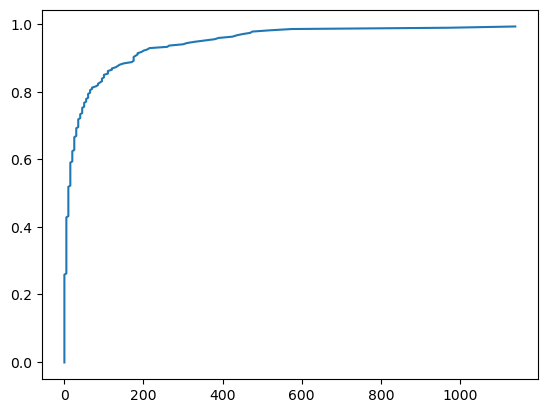

In [73]:
sorted, pos = dnw.cunnane_empircal_cdf(all_summ[files[0]]['lifetime'].values)

fig, ax = plt.subplots()
ax.plot(sorted, pos)

/tmp/ipykernel_4078874/1114308711.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma')
/tmp/ipykernel_4078874/1114308711.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


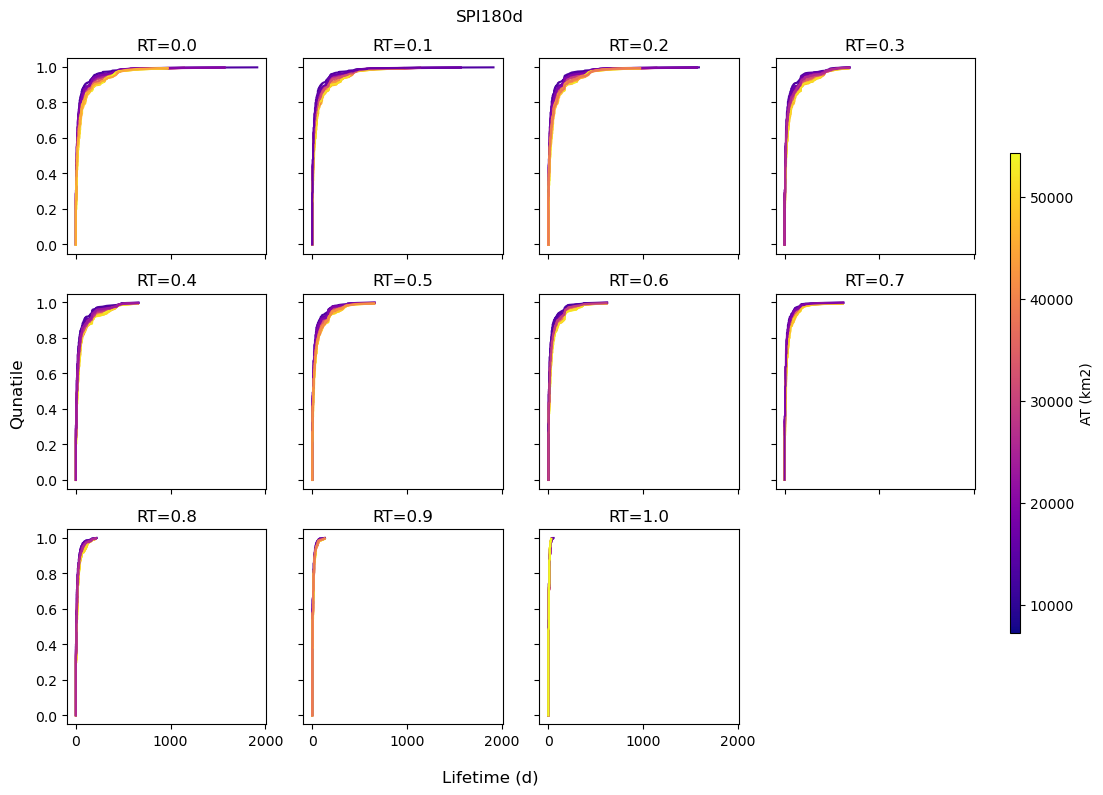

In [74]:
fig, axs = plt.subplots(3,4, figsize=(10,8), sharex=True, sharey=True)

cmap = plt.cm.get_cmap('plasma')

ax_rav = axs.ravel()

for file in files:
    sorted, pos = dnw.cunnane_empircal_cdf(all_summ[file]['lifetime'].values)
    a_thresh, r_thresh = get_thresh_from_file(file)
    i = a_thresh_map[a_thresh]
    j = r_thresh_map[r_thresh]

    ax_rav[j].plot(sorted, pos, color=cmap(a_thresh/np.max(a_thresh_set)))
    ax_rav[j].set_title(f'RT={r_thresh}')

ax_rav[-1].axis('off')

fig.suptitle('SPI180d')
fig.supxlabel('Lifetime (d)')
fig.supylabel('Qunatile')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.02, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()

/tmp/ipykernel_4078874/825536473.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma')
/tmp/ipykernel_4078874/825536473.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


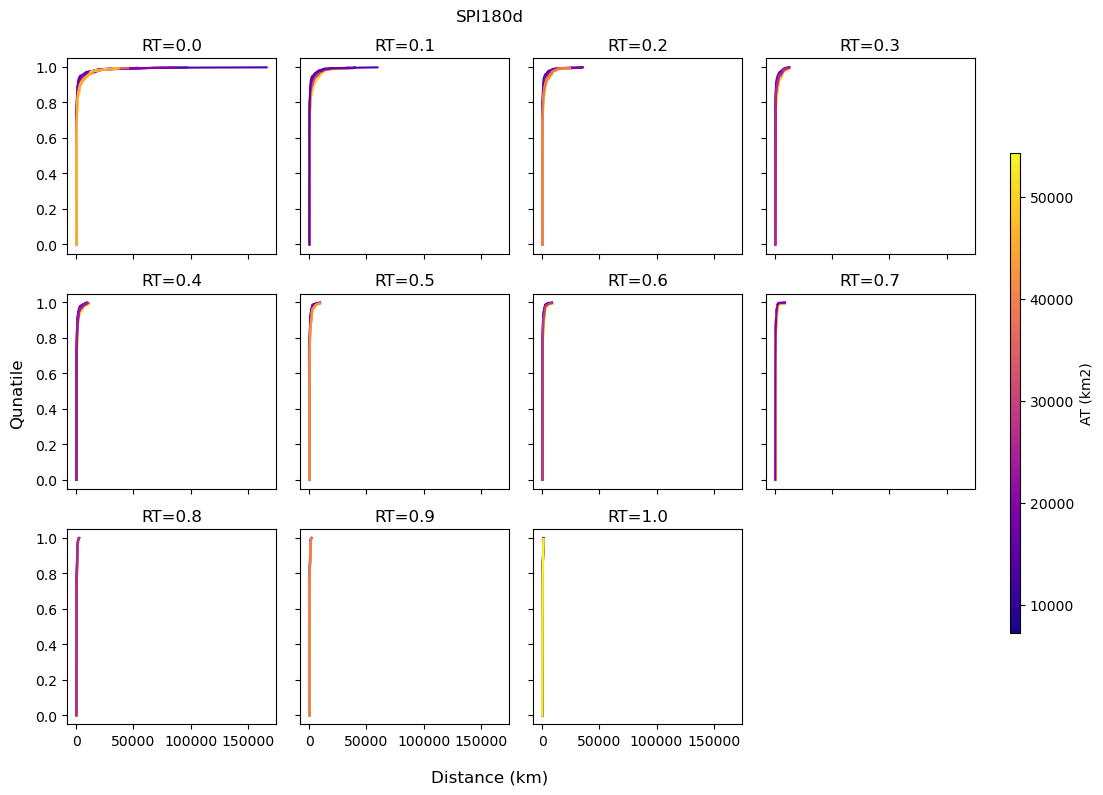

In [75]:
fig, axs = plt.subplots(3,4, figsize=(10,8), sharex=True, sharey=True)

ax_rav = axs.ravel()

cmap = plt.cm.get_cmap('plasma')


for file in files:
    sorted, pos = dnw.cunnane_empircal_cdf(all_summ[file]['distance'].values/1e3)
    a_thresh, r_thresh = get_thresh_from_file(file)
    i = a_thresh_map[a_thresh]
    j = r_thresh_map[r_thresh]

    ax_rav[j].plot(sorted, pos, color=cmap(a_thresh/np.max(a_thresh_set)))
    ax_rav[j].set_title(f'RT={r_thresh}')

ax_rav[-1].axis('off')

fig.suptitle('SPI180d')
fig.supxlabel('Distance (km)')
fig.supylabel('Qunatile')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.02, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()

/tmp/ipykernel_4078874/2303325659.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma')
/tmp/ipykernel_4078874/2303325659.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


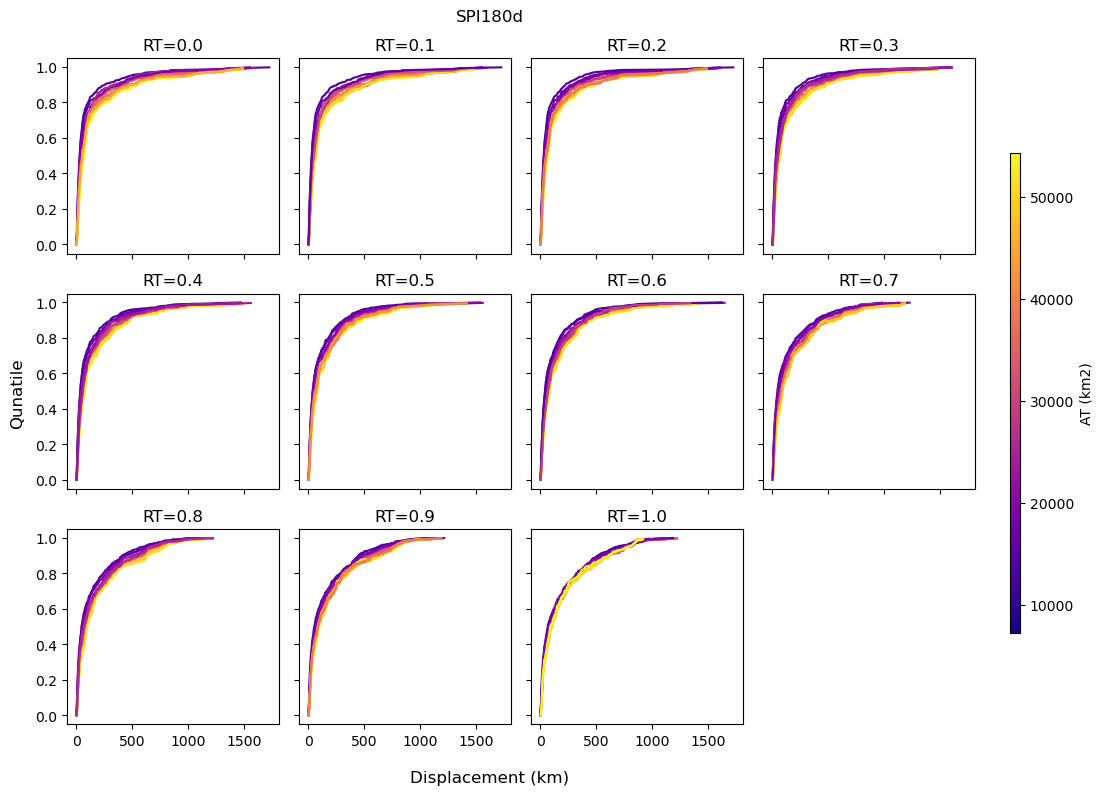

In [76]:
fig, axs = plt.subplots(3,4, figsize=(10,8), sharex=True, sharey=True)

ax_rav = axs.ravel()

cmap = plt.cm.get_cmap('plasma')


for file in files:
    sorted, pos = dnw.cunnane_empircal_cdf(all_summ[file]['displacement'].values/1e3)
    a_thresh, r_thresh = get_thresh_from_file(file)
    i = a_thresh_map[a_thresh]
    j = r_thresh_map[r_thresh]

    ax_rav[j].plot(sorted, pos, color=cmap(a_thresh/np.max(a_thresh_set)))
    ax_rav[j].set_title(f'RT={r_thresh}')

ax_rav[-1].axis('off')

fig.suptitle('SPI180d')
fig.supxlabel('Displacement (km)')
fig.supylabel('Qunatile')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.02, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()

/tmp/ipykernel_4078874/3199937757.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma')
/tmp/ipykernel_4078874/3199937757.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


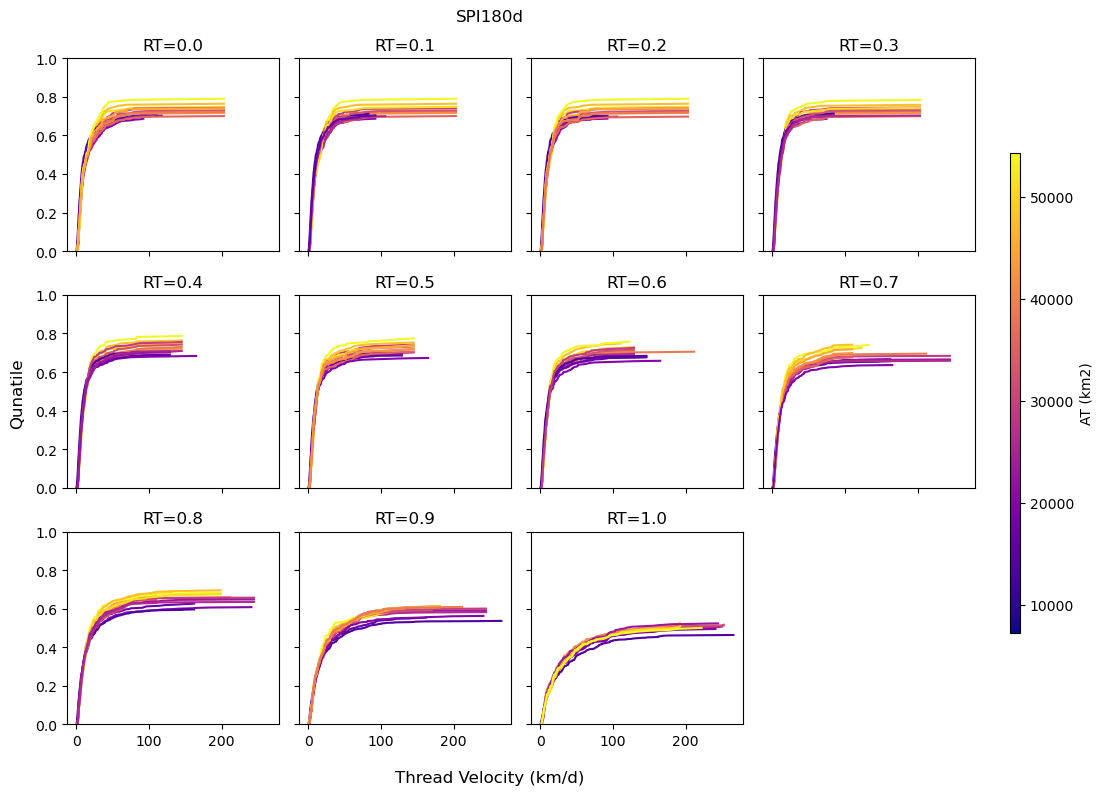

In [77]:
fig, axs = plt.subplots(3,4, figsize=(10,8), sharex=True, sharey=True)

ax_rav = axs.ravel()

cmap = plt.cm.get_cmap('plasma')


for file in files:
    sorted, pos = dnw.cunnane_empircal_cdf(all_summ[file]['average velocity'].values/1e3)
    a_thresh, r_thresh = get_thresh_from_file(file)
    i = a_thresh_map[a_thresh]
    j = r_thresh_map[r_thresh]

    ax_rav[j].plot(sorted, pos, color=cmap(a_thresh/np.max(a_thresh_set)))
    ax_rav[j].set_title(f'RT={r_thresh}')
    ax_rav[j].set_ylim(0,1)

ax_rav[-1].axis('off')

fig.suptitle('SPI180d')
fig.supxlabel('Thread Velocity (km/d)')
fig.supylabel('Qunatile')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.02, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()

/tmp/ipykernel_4078874/4052864998.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma')
/tmp/ipykernel_4078874/4052864998.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


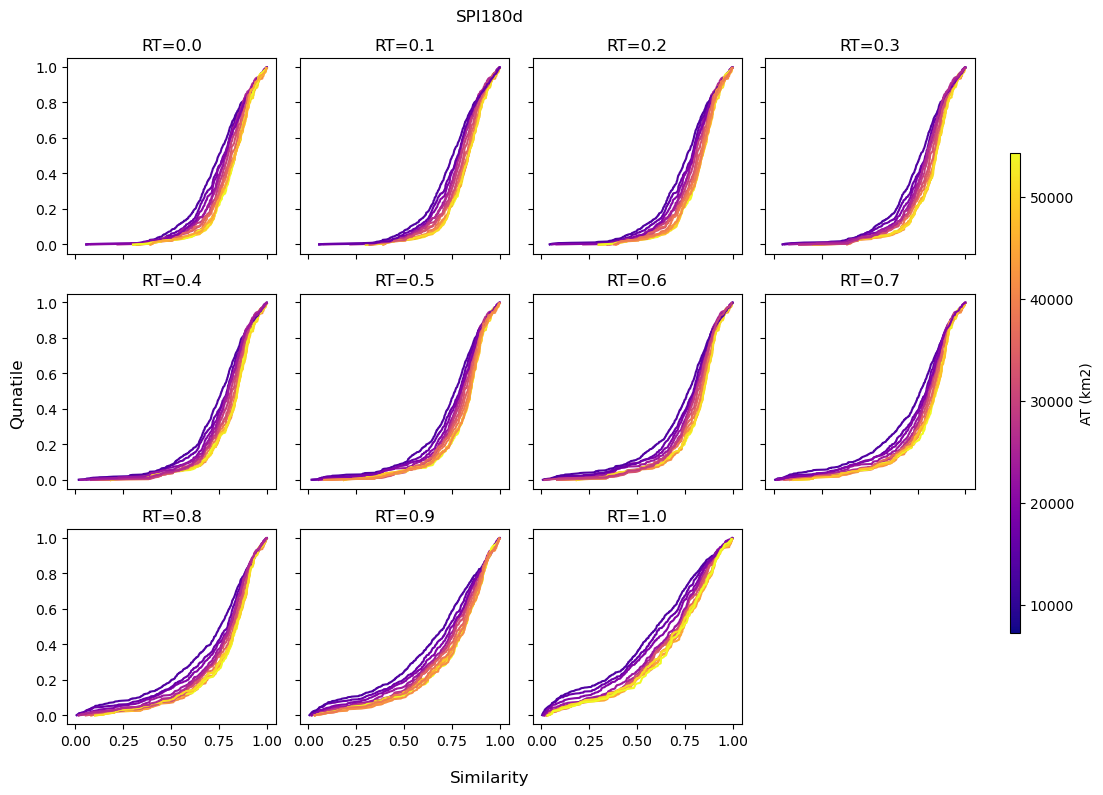

In [78]:
fig, axs = plt.subplots(3,4, figsize=(10,8), sharex=True, sharey=True)

ax_rav = axs.ravel()

cmap = plt.cm.get_cmap('plasma')


for file in files:
    sorted, pos = dnw.cunnane_empircal_cdf(all_summ[file]['similarity'].values)
    a_thresh, r_thresh = get_thresh_from_file(file)
    i = a_thresh_map[a_thresh]
    j = r_thresh_map[r_thresh]

    ax_rav[j].plot(sorted, pos, color=cmap(a_thresh/np.max(a_thresh_set)))
    ax_rav[j].set_title(f'RT={r_thresh}')

ax_rav[-1].axis('off')

fig.suptitle('SPI180d')
fig.supxlabel('Similarity')
fig.supylabel('Qunatile')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.02, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()